In [1]:
# computing pi value with PySpark

In [8]:
from random import random
from operator import add
import pyspark
try:
    sc = pyspark.SparkContext('local[*]')
except:
    sc = sc
partitions = 10
n = 100000 * partitions
#function which evaluates if the random x,y point is inside the unit circle
def f(_):
    x = random() * 2 - 1
    y = random() * 2 - 1
    return 1 if x ** 2 + y ** 2 < 1 else 0
#parallelize = make a range of keys and partition keys to x partitions
#assing a value to each key with .map(f)
#and finally reduce the values by summation
count = sc.parallelize(range(1, n + 1), partitions).map(f).reduce(add)
print("Pi is roughly %f" % (4.0 * count / n))
sc.stop()

Pi is roughly 3.140748


In [9]:
# Mapper and reducer

In [10]:
import pyspark
try:
    sc = pyspark.SparkContext('local[*]')
except:
    sc = sc
lines = sc.textFile("names*.txt")
words = lines.map(lambda line: line.replace(".","").replace(",","").replace("?","").replace("\t","").replace(":","").replace("!","") \
                    .replace("-","").lower()).flatMap(lambda line: line.split(" "))
counts = words.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)
#retrieve at most 200 key value pairs from the rdd (it’s not wise to try to get everything)
for x in counts.take(200):
    print(x)
sc.stop()

('lasse', 1)
('anna', 1)
('johanna', 1)
('teemu', 1)
('tuulikki', 1)
('pekka', 3)
('teuvo', 1)
('pikkumyy', 1)
('jorma', 1)
('tellervo', 1)
('ka%ti', 1)
("'tyyne", 1)
("urpo'%", 1)
('turpo', 1)


In [2]:
# Histogram of the word length

Comment for task 3: I modified the code in such a way that removes all code to not return zero length words by using filter function as below

<IPython.core.display.Javascript object>


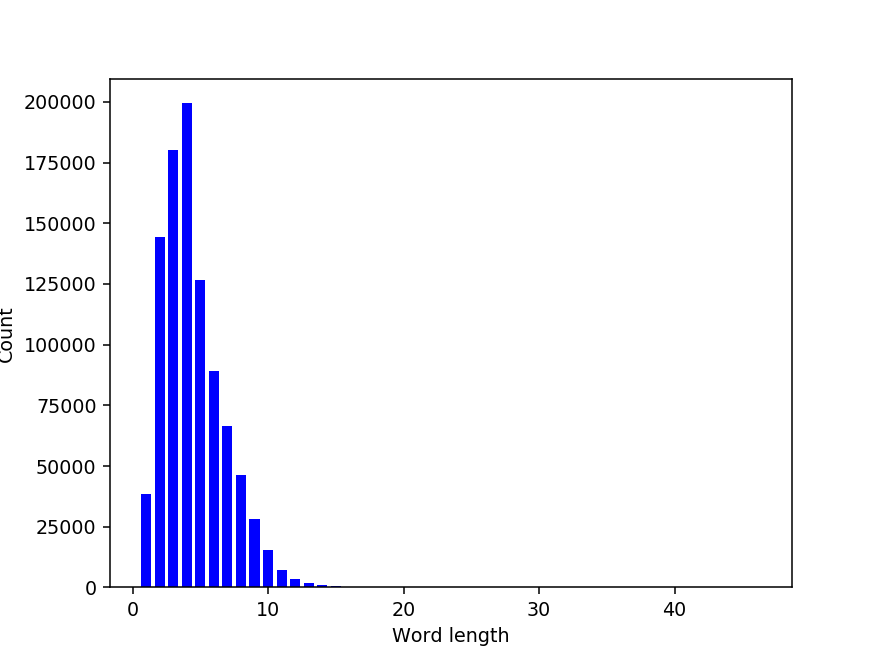

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 33, 36, 38, 40, 46)
(38509, 144143, 180322, 199366, 126746, 89190, 66579, 46366, 28156, 15253, 7303, 3313, 1654, 870, 389, 200, 85, 33, 22, 12, 4, 3, 2, 3, 1, 1, 2, 1, 1, 1, 1, 1)


In [5]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import pyspark
try:
    sc = pyspark.SparkContext('local[*]')
except:
    sc = sc
lines = sc.textFile("*.txt")
words = lines.flatMap(lambda line: line.split(" "))
white_spaces = words.filter(lambda line:line!='')
counts = white_spaces.map(lambda word: (len(word),1)). reduceByKey(lambda a, b: a + b).sortByKey()

#retrieve all data from the rdd and split keys and values to x and y lists
cnt = counts.collect()
x, y = zip(*cnt)
fig = plt.figure()

    
plt.bar(x, y, 0.75, color='b')
plt.xlabel('Word length')
plt.ylabel('Count')
fig.savefig('word lenght.png', dpi=200)    
print(x)
print(y)
    
sc.stop()

In [3]:
# Data parsing, querying and SQLContext 

In [1]:
#python imports
import pyspark
from pyspark.sql import SQLContext, Row

#connect to the spark. This is where we tell how to connect to our cluster
#we use local cluster, meaning that instance runs on single computer 
#using whatever number of processors
try:
    sc = pyspark.SparkContext('local[*]')
except:
    sc = sc

#create sqlcontext on the spark, enables the use of the SQL queries below
sqlContext = SQLContext(sc)

#python function definition to parse text to number, in case we cannot convert set -1 as error value
def fixedint(s):
    try:
        s=int(s)
    except ValueError:
        #return -1 if integer conversion fails
        s=-1    
    return s

#our input file with data as lines of text from local file
lines = sc.textFile("routes.dat")
#split lines to items by comma
items = lines.map(lambda l: l.split(","))
#convert items on rows to dataframe Row
routes = items.map(lambda p: Row( Airline=p[0], Airline_ID=fixedint(p[1]), \
                                  Source_airport=p[2], \
                                  Source_ID=fixedint(p[3]), \
                                  Destination_airport=p[4], \
                                  Destination_ID=fixedint(p[5]), \
                                  Codeshare=p[6], Stops=fixedint(p[7]), \
                                  Equipment=p[8]))

print(' Peek data for 5 rows\n')
#fetch 5 elements from the rdd and print them
for x in routes.take(5):
    print(x)

#convert our rows to sqlcontext dataframe
routedf = sqlContext.createDataFrame(routes)
#set schema
routedf.registerTempTable("routes")

#make a query to the data, this select all routes with CR2 plane type
result = sqlContext.sql("SELECT * FROM routes WHERE Destination_airport='LAX' or Source_airport ='LAX' ")
number_of_routes = sqlContext.sql("SELECT count(*) as Number_of_flight FROM routes WHERE Destination_airport='LAX' or Source_airport ='LAX' ")

print('\n Query results: \n')
#fetch results from the cluster
#note be careful, in big data this kind of call could print billions rows (and crash)!
number_of_routes.persist()
number_of_routes.show(result.count())
result.persist()
result.show(result.count())

result.coalesce(1).write.format('csv').save("output.csv", header='true');

sc.stop()

 Peek data for 5 rows

Row(Airline='2B', Airline_ID=410, Codeshare='', Destination_ID=2990, Destination_airport='KZN', Equipment='CR2', Source_ID=2965, Source_airport='AER', Stops=0)
Row(Airline='2B', Airline_ID=410, Codeshare='', Destination_ID=2990, Destination_airport='KZN', Equipment='CR2', Source_ID=2966, Source_airport='ASF', Stops=0)
Row(Airline='2B', Airline_ID=410, Codeshare='', Destination_ID=2962, Destination_airport='MRV', Equipment='CR2', Source_ID=2966, Source_airport='ASF', Stops=0)
Row(Airline='2B', Airline_ID=410, Codeshare='', Destination_ID=2990, Destination_airport='KZN', Equipment='CR2', Source_ID=2968, Source_airport='CEK', Stops=0)
Row(Airline='2B', Airline_ID=410, Codeshare='', Destination_ID=4078, Destination_airport='OVB', Equipment='CR2', Source_ID=2968, Source_airport='CEK', Stops=0)

 Query results: 

+----------------+
|Number_of_flight|
+----------------+
|             990|
+----------------+

+-------+----------+---------+--------------+-----------------

Comment for task 7:The output file is filtered due to the sql function we used. excel file now contains the all routes that landing to the LAX or departing from the LAX.

In [4]:
# MapReduce with Spark and Counting the word occurrences. With Spark!

In [18]:
import sys
 
from pyspark import SparkContext, SparkConf

try:
    sc = pyspark.SparkContext('local[*]')
except:
    sc = sc

lines = sc.textFile("names*.txt")
def Punctuation(x):
  punc='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~-'
  lowercased_str = x.lower()
  for ch in punc:
    lowercased_str = lowercased_str.replace(ch, '')
  return lowercased_str

lines = lines.map(Punctuation)
words = lines.flatMap(lambda line: line.split(" "))

# count the occurrence of each word
wordCounts = words.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b).sortByKey()
cnts = wordCounts.count()
print("Number of occurence is ",cnts)
for x in wordCounts.take(200):
    print(x)
sc.stop()


Number of occurence is  14
('anna', 1)
('johanna', 1)
('jorma', 1)
('kati', 1)
('lasse', 1)
('pekka', 3)
('pikkumyy', 1)
('teemu', 1)
('tellervo', 1)
('teuvo', 1)
('turpo', 1)
('tuulikki', 1)
('tyyne', 1)
('urpo', 1)


In [19]:
# Task 9

<IPython.core.display.Javascript object>


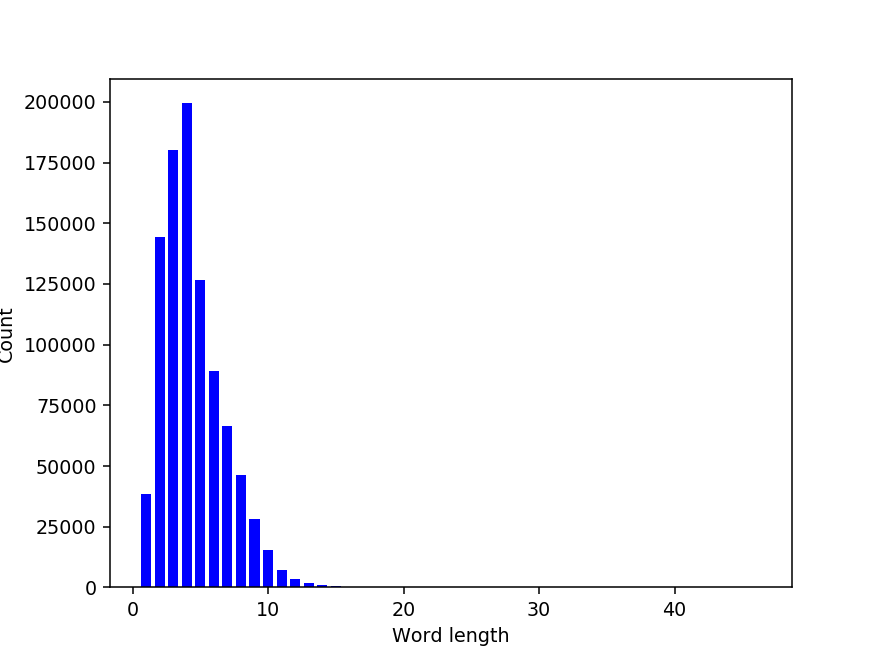

[(1, 38509), (2, 144143), (3, 180322), (4, 199365), (5, 126737), (6, 89188), (7, 66578), (8, 46364), (9, 28155), (10, 15253), (11, 7303), (12, 3313), (13, 1654), (14, 870), (15, 389), (16, 200), (17, 85), (18, 33), (19, 22), (20, 12), (21, 4), (22, 3), (23, 2), (24, 3), (25, 1), (27, 1), (28, 2), (33, 1), (36, 1), (38, 1), (40, 1), (46, 1)]


In [6]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import pyspark
try:
    sc = pyspark.SparkContext('local[*]')
except:
    sc = sc

lines = sc.textFile("all-shakespeare_notab.txt")
words = lines.flatMap(lambda line: line.split(" "))
white_spaces = words.filter(lambda line:line!='')
counts = white_spaces.map(lambda word: (len(word),1)) \
              .reduceByKey(lambda a, b: a + b).sortByKey()
#retrieve all data from the rdd and split keys and values to x and y lists
cnts = counts.collect()
x, y = zip(*cnts)

fig = plt.figure()   
plt.bar(x, y, 0.75, color='b')
plt.xlabel('Word length')
plt.ylabel('Count')
fig.savefig('word lenght task 9.png', dpi=200) 

    
print(cnts)
    
sc.stop()